# Piecewise Regression

Piecewise regression is a model in which the independent variable is partitioned into intervals, and the dependent variable is a piecewise linear function of the independent variable.

In this tutorial, we will implement piecewise regression and train it using SVI. Then we will look at exploiting the piecewise structure of the model for more robust and efficient inference.

### Tutorial Outline

### Setup

In [1]:
from tqdm import tqdm
import numpy as np
import torch
import pyro
from pyro.distributions import *
from pyro.infer import SVI, Trace_ELBO

from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer.autoguide.initialization import init_to_sample

import matplotlib.pyplot as plt

In [2]:
pyro.set_rng_seed(0)

### Synthetic data

Let's generate some piecewise linear data. First let's sample the independent variable, slopes, breakpoints (or knots), the observation noise level and the first intercept.

In [3]:
n_pieces = 5
N = 700
x = torch.rand(N).sort()[0]*100
slopes = Uniform(-3,3).sample([n_pieces])
knots,_ = Uniform(0,N).sample([n_pieces-1]).sort()
knots = knots.long()
intercepts = [Uniform(-10,10).sample()]
y_noise = 3.

Now, let's sample the dependent variable for each piece, solving for the intercept such that the pieces are connected.

In [4]:
y = []
prev_knot = 0
for i,knot in enumerate(knots):
    y.append(Normal(slopes[i]*x[prev_knot:knot]+intercepts[i],y_noise).sample())
    intercepts.append(slopes[i]*x[knot]+intercepts[i] - slopes[i+1]*x[knot])
    prev_knot = knot
    
y.append(Normal(slopes[-1]*x[knots[-1]:]+intercepts[-1],y_noise).sample())
y = torch.cat(y)

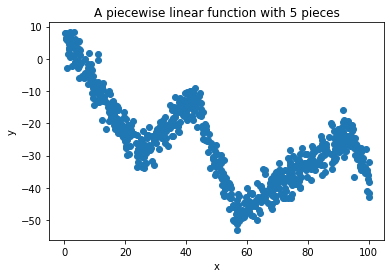

In [5]:
plt.scatter(x,y)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'A piecewise linear function with {n_pieces} pieces');

### Model

As above, the model should sample the various parameters, and produce piecewise linear data. But we'd like to vectorize the model, in order to efficiently compute low-variance ELBO gradient estimates during inference.
* We already know the x-coordinates of the first and last knot, which we get from the smallest and largest observed x. So we sample the x-coordinate for the knots in the middle, and the y-coordinates for all knots. 
* To avoid optimizing over a large parameter space, we scale the knot coordinates down, such that the x-coordinates take values in the unit interval, and the y-coordinates are standard Normal distributed.
* Given the knot coordinates, we need to evaluate the piecewise linear function in a vectorized manner. We do this by constructing arrays which, for each observed data-point, contain the coordinates of the knots which define the piece to which the data-point belongs. We can then compute the slopes in one line and likewise the intercepts.
* Having evaluated the mean of the data, we sample the observations from a Normal distribution with a LogNormal-distributed scale parameter.

In [6]:
def piecewise_eval(knot_x, knot_y, x):
    n_knots = knot_x.size(-1)
    assert n_knots >= 2
    knot_x, idx = knot_x.sort(dim=-1)
    knot_y = knot_y.gather(-1,idx)
    lb = (x.unsqueeze(-1) > knot_x[...,1:].unsqueeze(-2)).long().sum(-1)
    lb[lb >= n_knots - 1] = n_knots - 2
    ub = lb + 1
    x0 = knot_x.gather(-1,lb)
    x1 = knot_x.gather(-1,ub)
    y0 = knot_y.gather(-1,lb)
    y1 = knot_y.gather(-1,ub)
    slopes = (y1-y0)/(x1-x0).clamp(min=1e-8)
    return slopes*x + (y1 - slopes*x1)

In [7]:
def piecewise_regression(x, y, n_knots=3):
    x_knot_prior = Uniform(0, 1)
    knot_x = pyro.sample("knot_x",
                         x_knot_prior
                             .expand([n_knots-2]).to_event(0))
    knot_y = pyro.sample("knot_y",
                         Normal(0, 1)
                             .expand([n_knots]).to_event(0))
    knot_shape = knot_x.shape[:-1] + (1,)
    knot_x = torch.cat([torch.zeros(knot_shape), knot_x, torch.ones(knot_shape)], dim=-1)
    x_len = x.max()-x.min()
    y_pred = piecewise_eval(x_len*knot_x, x_len*knot_y, x)
    y_scale = pyro.sample("y_scale", LogNormal(0, 1))
    y = pyro.sample("obs", Normal(y_pred, y_scale),
                obs=y)
    return y

### Inference

For inference, we use an AutoGuide, and optimize the ELBO as a function of the guide's parameters with Adam.

In [8]:
guide = AutoDiagonalNormal(piecewise_regression,init_loc_fn=init_to_sample)

In [9]:
pyro.clear_param_store()

Setting the learning rate, and the number of particles, takes a bit of trial and error, moreso if there are many pieces.

In [10]:
optim = pyro.optim.Adam({"lr": 0.03})
elbo = Trace_ELBO(num_particles=10, vectorize_particles=True,max_plate_nesting=1)
svi = SVI(piecewise_regression, guide, optim, loss=elbo)

Also, the more pieces there are, the more iterations are needed to converge to a good minimum.

In [11]:
%%time
n_knots = n_pieces + 1
losses = []
for i in tqdm(range(5000)):
    losses.append(svi.step(x,y,n_knots))

100%|██████████| 5000/5000 [00:27<00:00, 183.24it/s]

CPU times: user 1min 47s, sys: 544 ms, total: 1min 47s
Wall time: 27.3 s


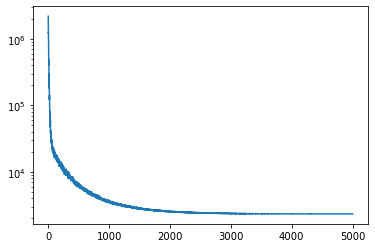

In [12]:
plt.plot(losses)
plt.yscale('log')

### Evaluation

We can evaluate the fit visually by sampling from the posterior predictive distribution. Here we draw 100 samples.

In [13]:
pred = pyro.infer.predictive.Predictive(pyro.poutine.uncondition(piecewise_regression),guide=guide,num_samples=100)

fit = pred(x,y,n_knots)

fit_obs_mean = fit['obs'].mean(0).detach()
fit_obs_std = fit['obs'].std(0).detach()

<ErrorbarContainer object of 3 artists>

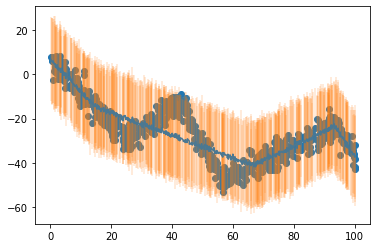

In [14]:
%matplotlib inline
plt.scatter(x,y)
plt.plot(x,fit_obs_mean)
plt.errorbar(x,fit_obs_mean,yerr=3*fit_obs_std,alpha=.2)

### Inference with split moves

The fit could be worse, but it's clear that, in a sense, the problem hasn't been solved. Instead, the optimizer seems to have gotten stuck in a local minimum. We could try different initializations, and try different learning rates, perhaps different numbers of particles to adjust the gradient variance.

A different approach is to exploit the structure of the model. We see that the fit is fine for the lowest and highest values of x. If we could keep those parts, and split the piece in the middle, we might get a better fit. Let's formalize and implement this inference strategy.

In [15]:
pyro.clear_param_store()

Splitting pieces in two means adding a knot parameters, in the location where the split is done. In order to make working with parameters easier, let's first write a custom guide. It's similar to the AutoDiagonalNormal guide, but we additionally constrain the x-coordinate of the knots to be on the unit interval.

In [16]:
def piecewise_guide(x, y, n_knots=3):
    knot_x_loc = pyro.param('knot_x_loc', torch.linspace(0,1,n_knots)[1:-1], constraint=constraints.unit_interval)
    knot_x_scale = pyro.param('knot_x_scale', torch.abs(torch.randn(n_knots-2)), constraint = constraints.positive)
    knot_x = pyro.sample("knot_x",
                         Normal(knot_x_loc, knot_x_scale).to_event(0))

    knot_y_loc = pyro.param('knot_y_loc', torch.randn(n_knots))
    knot_y_scale = pyro.param('knot_y_scale', torch.abs(torch.randn(n_knots)), constraint = constraints.positive)
    knot_y = pyro.sample("knot_y",
                         Normal(knot_y_loc, knot_y_scale).to_event(0))
    
    y_scale_loc = pyro.param('y_scale_loc', torch.randn(1))
    y_scale_scale = pyro.param('y_scale_scale', torch.abs(torch.randn(1)), constraint = constraints.positive)
    y_scale = pyro.sample("y_scale", LogNormal(y_scale_loc, y_scale_scale))
    return knot_x, knot_y, y_scale

Let's wrap the inference and evaluation from before into functions.

In [17]:
def inferece(n_knots, losses = [], n_iter = 100):
    optim = pyro.optim.Adam({"lr": 0.03})
    elbo = Trace_ELBO(num_particles=10, vectorize_particles=True,max_plate_nesting=1)
    svi = SVI(piecewise_regression, piecewise_guide, optim, loss=elbo)
    for i in tqdm(range(n_iter)):
        losses.append(svi.step(x,y,n_knots))
    return losses

In [18]:
def evaluate():
    pred = pyro.infer.predictive.Predictive(pyro.poutine.uncondition(piecewise_regression),guide=piecewise_guide,num_samples=100)
    fit = pred(x,y,n_knots)
    return fit

Before splitting a piece, we need to identify which piece is in most need of splitting. A straightforward way to do this is to evaluate the probability of the observed data given the model, within each piece. We return the index (counting from left to right) of the worst fitting piece.

In [19]:
def worst_fitting_piece(fit):
    # get all sampled knots
    knots = x.max()*fit['knot_x'].sort()[0]

    # identify the indexes of x that make up the pieces
    lb = torch.cat([torch.zeros(100,1), knots], dim=-1).unsqueeze(-1)
    ub = torch.cat([knots, x.max()*torch.ones(100,1)], dim=-1).unsqueeze(-1)

    x_greater_than_lb = x.unsqueeze(-2) >= lb
    x_less_than_ub = x.unsqueeze(-2) <= ub

    pieces_idx = x_greater_than_lb*x_less_than_ub
    # compute log_prob of all data under current model
    log_probs = Normal(fit['obs'], fit['y_scale'].unsqueeze(-1)).log_prob(y)

    pieces_idx = pieces_idx.permute(-2,-3,-1)
    # average log_prob for each piece
    logprobs = []
    for i in range(knots.shape[1]+1):
        logprobs.append(log_probs[pieces_idx[i]].mean())
    # return idx of piece with lowest log_prob
    idx = torch.argmin(torch.tensor(logprobs))
    return idx

Having identified which piece we want to split, we construct a new knot in the middle of it. We add the new knot to the location and scale parameters of the x- and y-coordinates, and populate the parameter store anew.

In [20]:
def compute_split_params(idx):
    # split the idx'th piece in two
    n_knots = pyro.param('knot_x_loc').shape[0] + 2
    padded_knots = torch.zeros(n_knots)
    padded_knots[1:-1] = pyro.param('knot_x_loc')
    padded_knots[-1] = 1.
    # new loc parameter of the x-coordinate is average of start- and end- knot
    # same with scale paramater
    # same with y_loc and and y_scale
    new_x_knot_loc = torch.cat([pyro.param('knot_x_loc')[:idx], padded_knots[idx:idx+2].mean().unsqueeze(-1), pyro.param('knot_x_loc')[idx:]])
    new_x_knot_scale = torch.cat([pyro.param('knot_x_scale')[:idx], pyro.param('knot_x_scale').mean().unsqueeze(-1), pyro.param('knot_x_scale')[idx:]])
    new_y_knot_loc = torch.cat([pyro.param('knot_y_loc')[:idx+1], pyro.param('knot_y_loc')[idx:idx+2].mean().unsqueeze(-1), pyro.param('knot_y_loc')[idx+1:]])
    new_y_knot_scale = torch.cat([pyro.param('knot_y_scale')[:idx+1], pyro.param('knot_y_scale')[idx:idx+2].mean().unsqueeze(-1), pyro.param('knot_y_scale')[idx+1:]])
    # noise level is unchanged
    new_y_scale_loc = pyro.param('y_scale_loc')
    new_y_scale_scale = pyro.param('y_scale_scale')
    
    # clear param store and init new params
    pyro.clear_param_store()
    pyro.param('knot_x_loc', new_x_knot_loc.detach())
    pyro.param('knot_x_scale', new_x_knot_scale.detach(), constraint = constraints.positive)
    pyro.param('knot_y_loc', new_y_knot_loc.detach())
    pyro.param('knot_y_scale', new_y_knot_scale.detach(), constraint = constraints.positive)
    pyro.param('y_scale_loc', new_y_scale_loc.detach())
    pyro.param('y_scale_scale', new_y_scale_scale.detach(), constraint = constraints.positive)

In [21]:
def plot_fit(fit):
    fit_obs_mean = fit['obs'].mean(0).detach()
    fit_obs_std = fit['obs'].std(0).detach()

    plt.figure()
    plt.scatter(x,y)
    plt.plot(x,fit_obs_mean)
    plt.errorbar(x,fit_obs_mean,yerr=3*fit_obs_std,alpha=.2)

Let's try it out. We'll start with a two-piece model, and iteratively split and infer one piece at a time, until we reach five pieces.

100%|██████████| 100/100 [00:00<00:00, 179.51it/s]


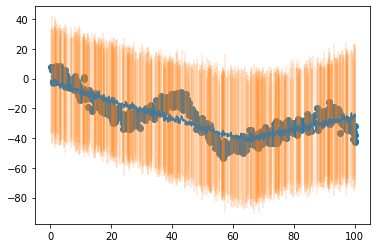

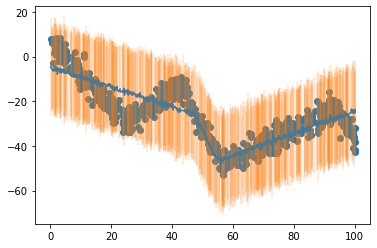

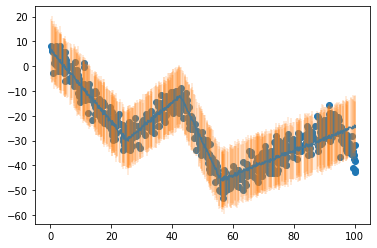

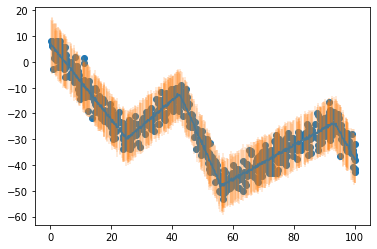

In [22]:
n_knots = 3
losses = []
losses = inferece(n_knots, losses, n_iter = 3000)
for _ in range(3):
    fit = evaluate()
    plot_fit(fit)
    idx = worst_fitting_piece(fit)
    compute_split_params(idx)
    n_knots += 1
    losses = inferece(n_knots, losses)
fit = evaluate()
plot_fit(fit)

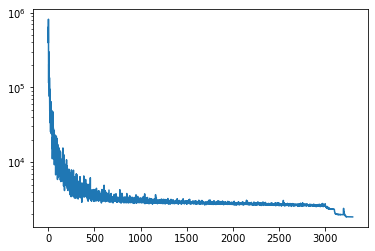

In [23]:
plt.plot(losses)
plt.yscale('log')

As we see from the plot, almost all computation went into fitting the two-piece model. Once a split is made, the optimizer requires only a few dozen iterations to find a new minimum.